Columns in DataFrame: ['Date', 'TV_Spend', 'Social_Spend', 'Radio_Spend', 'Sales', 'TV_Adstock', 'Social_Adstock', 'Radio_Adstock', 'Week']
Training on 124 weeks (Past)
Testing on 32 weeks (Future)
Tuning hyperparameters...
✅ Best Alpha Found: 0.001

--- PRO MODEL PERFORMANCE ---
Test MAPE: 6.27% (Error Rate)
Test R2:   0.4899 (Fit Quality)


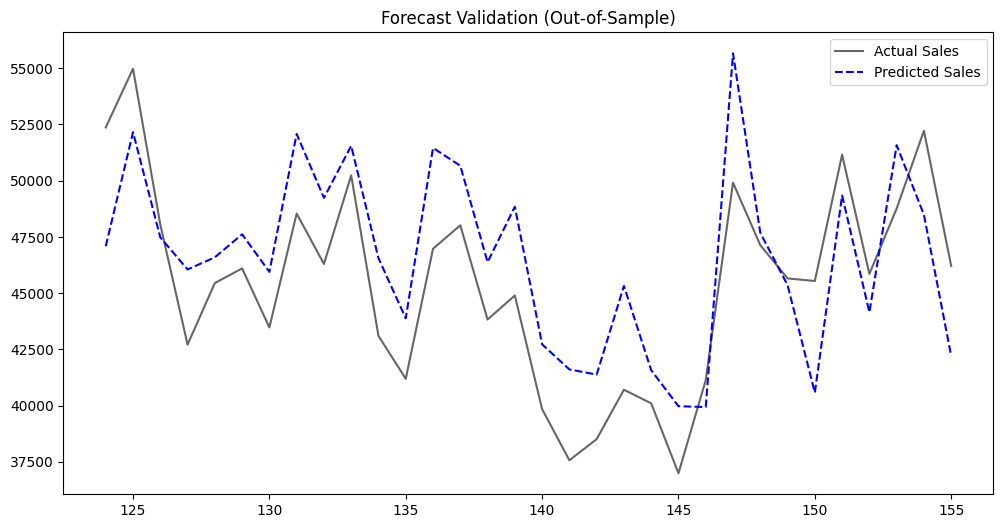


✅ Model serialized to src/mmm_model.pkl


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import joblib
import os

# ==========================================
# 1. LOAD DATA & SETUP
# ==========================================
df = pd.read_csv('../data/processed/mmm_feature_engineered.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date') # CRITICAL: Ensure time is sorted!

# --- FIX: RE-CREATE THE WEEK COLUMN ---
# We calculated this in the previous notebook but didn't save it to the CSV.
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
# --------------------------------------

# Define features and target
features = ['TV_Adstock', 'Social_Adstock', 'Radio_Adstock', 'Week']
target = 'Sales'

# Double check columns exist
print("Columns in DataFrame:", df.columns.tolist())

X = df[features]
y = df[target]

# ==========================================
# 2. PROFESSIONAL SPLIT (NO RANDOM SHUFFLE)
# ==========================================
# We train on the first 80% of time, test on the last 20%
train_size = int(len(df) * 0.80)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training on {len(X_train)} weeks (Past)")
print(f"Testing on {len(X_test)} weeks (Future)")

# ==========================================
# 3. HYPERPARAMETER TUNING (FINDING THE BEST ALPHA)
# ==========================================
# We don't guess alpha. We test alpha = 0.001 to 100.0 to find the sweet spot.
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0]}

# TimeSeriesSplit: Replicates the passage of time during cross-validation
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=Ridge(),
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_percentage_error', # We want to minimize error
    n_jobs=-1
)

print("Tuning hyperparameters...")
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

print(f"Best Alpha Found: {best_alpha}")

# ==========================================
# 4. EVALUATION (REALITY CHECK)
# ==========================================
preds_test = best_model.predict(X_test)

mape = mean_absolute_percentage_error(y_test, preds_test)
r2 = r2_score(y_test, preds_test)

print("\n--- PRO MODEL PERFORMANCE ---")
print(f"Test MAPE: {mape:.2%} (Error Rate)")
print(f"Test R2:   {r2:.4f} (Fit Quality)")

# Visualization: Actual vs Predicted over time
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Sales', color='black', alpha=0.6)
plt.plot(y_test.index, preds_test, label='Predicted Sales', color='blue', linestyle='--')
plt.title("Forecast Validation (Out-of-Sample)")
plt.legend()
plt.show()

# ==========================================
# 5. SERIALIZATION (SAVE THE BRAIN)
# ==========================================
# We save EVERYTHING the dashboard needs into one file.
model_artifacts = {
    "model": best_model,
    "features": features,
    "performance": {"MAPE": mape, "R2": r2},
    "adstock_params": {"TV": 0.85, "Social": 0.3, "Radio": 0.5}, 
    "saturation_params": {
        "TV": {"alpha": 10000, "beta": 1.5},     
        "Social": {"alpha": 5000, "beta": 1.5},
        "Radio": {"alpha": 2000, "beta": 1.5}
    }
}

os.makedirs('../src', exist_ok=True)
joblib.dump(model_artifacts, '../src/mmm_model.pkl')
print("Model serialized to src/mmm_model.pkl")